<a href="https://colab.research.google.com/github/priontu/Developing-a-Flower-Predictor-using-Keras-on-Tensorflow-and-ImageNet-models/blob/main/flower_predictor_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Transfer Learning Using Keras
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# dir(keras.applications) #Checking which engines are available/possible

In [4]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = True)

91884032/91884032 [==============================] - 0s 0us/step


In [ ]:
# base_model.summary()

In [5]:
trainSet, info = tfds.load(name='oxford_flowers102', split='train+validation', as_supervised=True, with_info=True)
validSet = tfds.load(name='oxford_flowers102', split='test[90%:]', as_supervised=True)
testSet = tfds.load(name='oxford_flowers102', split='test[:90%]', as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete38MKUF/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete38MKUF/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete38MKUF/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
# info.features['label'].names

In [ ]:
# info

In [6]:
nToAugment = 4
def augmentImages(image, label):
  resized_image = tf.image.resize_with_pad(image, 299, 299)
  imageL = [resized_image]
  myGen=keras.preprocessing.image.ImageDataGenerator(rotation_range=40, width_shift_range=[-.2,.2], brightness_range=[.6,1.0], shear_range=0.0, channel_shift_range=0.0, fill_mode='constant', cval=0.0, horizontal_flip=True, vertical_flip=True)
  augmented_images=[next(myGen.flow(resized_image)) for _ in range(nToAugment)]
  labels= [label.numpy() for _ in range(nToAugment+1)]
  imageL.extend(augmented_images)
  return imageL, labels

def augmentImagesTF(image, labels):
  func = tf.py_function(augmentImages, [image, labels], [tf.float32, tf.int32])
  return func

def mySqueeze(x, y):
  return tf.squeeze(x), y


In [7]:
trainPipeAug = trainSet.batch(1).prefetch(1).map(augmentImagesTF, num_parallel_calls=16).unbatch().map(mySqueeze, num_parallel_calls=16).shuffle(512)

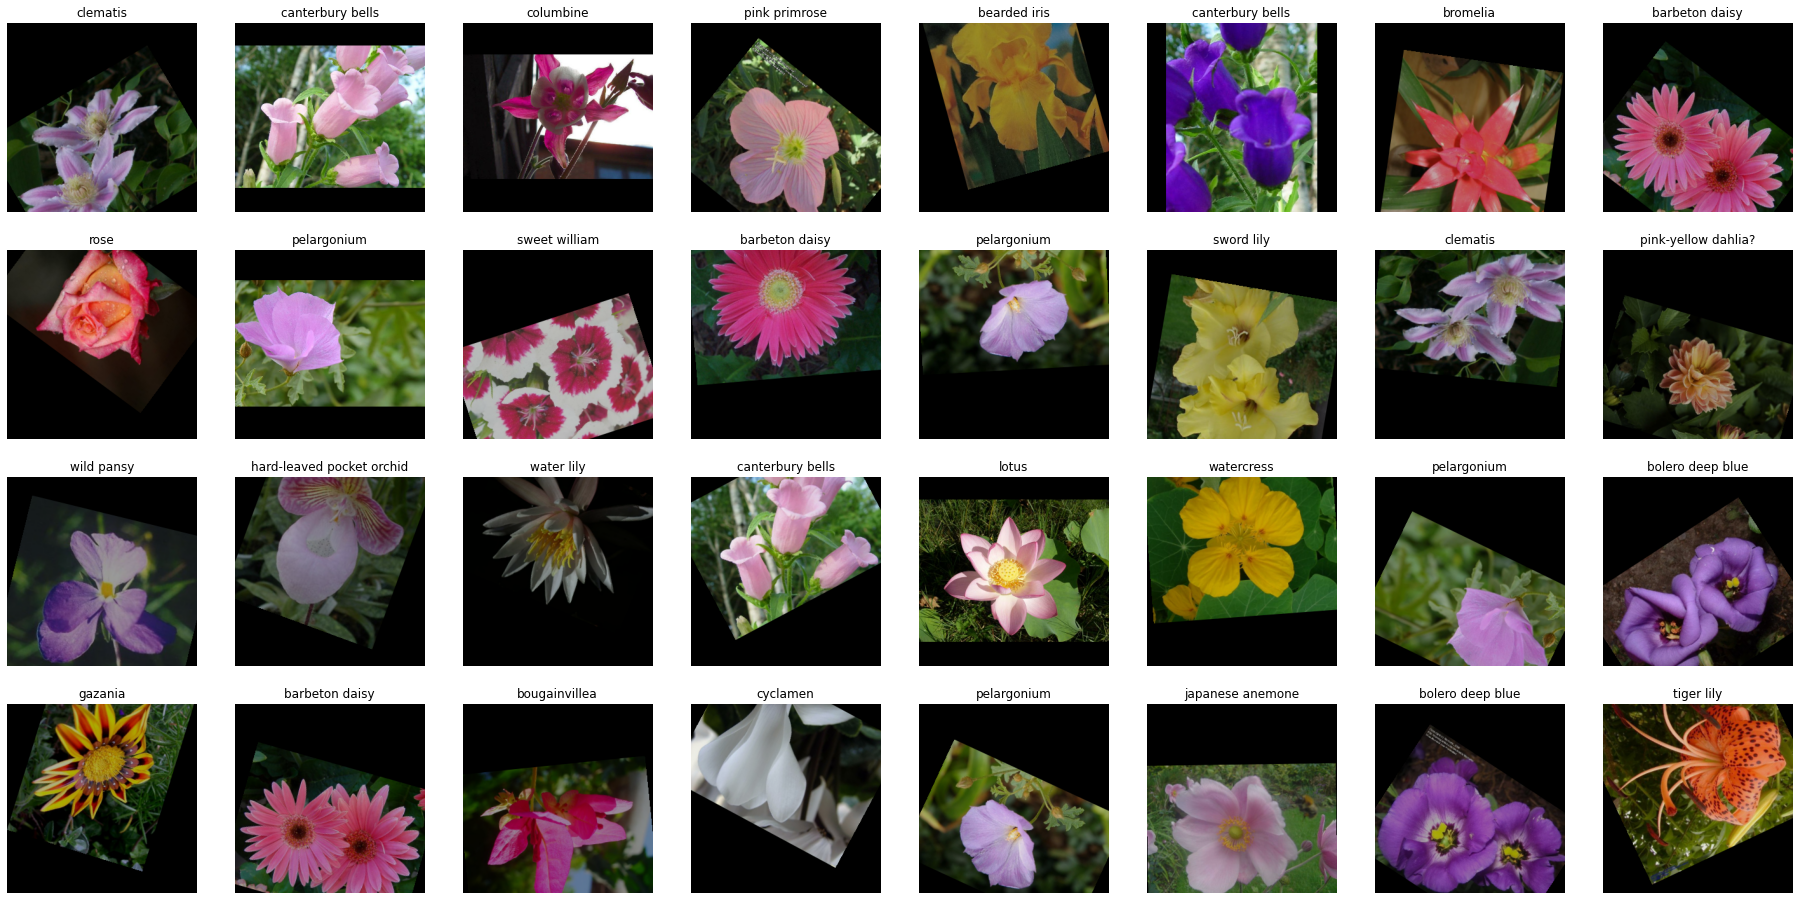

In [8]:
cnt = 1
plt.figure(figsize=(32, 16))
for inst in trainPipeAug.take(4*8):
  plt.subplot(4,8,cnt)
  plt.imshow(inst[0].numpy()/255)
  plt.axis('off')
  plt.title(info.features['label'].names[inst[1][0]])
  cnt = cnt + 1

In [9]:
def preproc(image, label):
  inp=keras.applications.xception.preprocess_input(image)
  return inp, label

def preprocessWithAspectRatio(image, label):
  resized_image=tf.image.resize_with_pad(image, 299, 299)
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

trainPipe=trainSet.map(preprocessWithAspectRatio, num_parallel_calls=8).batch(128).prefetch(1)
validPipe = validSet.map(preprocessWithAspectRatio, num_parallel_calls=8).batch(128).prefetch(1)
testPipe = testSet.map(preprocessWithAspectRatio, num_parallel_calls=8).batch(128).prefetch(1)


In [10]:
# base_model.layers[:-1]

In [11]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = False)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# base_model.summary()

In [12]:
base_model.output

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [13]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>

In [14]:
base_model.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>]

In [15]:
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(info.features['label'].num_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.inputs, outputs=output) # base_model.inputs or input?
# model.summary()

In [16]:
for layer in model.layers[:-2]:
  layer.trainable = False

# for layer in model.layers:
#   print(layer.trainable)

In [17]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('oxFLowersMod-topFit.h5', save_best_only=True)

earlyStop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)
ss=5e-1
# ss = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5.0,
#     decay_steps=10,
#     decay_rate=0.9)
# ss = 5
optimizer = keras.optimizers.SGD(learning_rate=ss)

model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
model.fit(trainPipe, validation_data= validPipe, epochs = 25, callbacks=[checkpoint_cb, earlyStop_cb])


Epoch 1/25
16/16 [==============================] - 47s 2s/step - loss: 4.2235 - accuracy: 0.1284 - val_loss: 3.6496 - val_accuracy: 0.3122
Epoch 2/25
16/16 [==============================] - 23s 1s/step - loss: 3.1912 - accuracy: 0.4691 - val_loss: 2.9114 - val_accuracy: 0.5577
Epoch 3/25
16/16 [==============================] - 23s 1s/step - loss: 2.4698 - accuracy: 0.6676 - val_loss: 2.3931 - val_accuracy: 0.6390
Epoch 4/25
16/16 [==============================] - 22s 1s/step - loss: 1.9742 - accuracy: 0.7701 - val_loss: 2.0303 - val_accuracy: 0.7008
Epoch 5/25
16/16 [==============================] - 24s 1s/step - loss: 1.6276 - accuracy: 0.8260 - val_loss: 1.7720 - val_accuracy: 0.7333
Epoch 6/25
16/16 [==============================] - 23s 1s/step - loss: 1.3780 - accuracy: 0.8564 - val_loss: 1.5831 - val_accuracy: 0.7610
Epoch 7/25
16/16 [==============================] - 23s 1s/step - loss: 1.1922 - accuracy: 0.8804 - val_loss: 1.4410 - val_accuracy: 0.7789
Epoch 8/25
16/16 [==

In [18]:
for layer in model.layers[:-2]:
  layer.trainable = True

In [19]:
trainSet, info = tfds.load(name = 'oxford_flowers102', split = 'train + validation', as_supervised = True, with_info = True)
validSet = tfds.load(name='oxford_flowers102', split='test[90%:]', as_supervised=True)
testSet = tfds.load(name='oxford_flowers102', split = 'test[:90%]', as_supervised=True)

def preprocessWithAspectRatio(image, label):
  resized_image=tf.image.resize_with_pad(image, 299, 299)
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

trainPipe=trainSet.map(preprocessWithAspectRatio, num_parallel_calls=32).batch(32).prefetch(1)
validPipe = validSet.map(preprocessWithAspectRatio, num_parallel_calls=32).batch(32).prefetch(1)
testPipe = testSet.map(preprocessWithAspectRatio, num_parallel_calls=32).batch(32).prefetch(1)


In [20]:
ss = 3e-2
# ss = 30
# ss = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=3,
#     decay_steps=10,
#     decay_rate=0.9)
f_path = "/content/gdrive/My Drive/flowerModel.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(f_path, save_best_only=True)

earlyStop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)
# ss=5e-1
# ss = 50
# optimizer = keras.optimizers.SGD(learning_rate=ss)

model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])


In [21]:
model.fit(trainPipe, validation_data= validPipe, epochs = 50, callbacks=[checkpoint_cb, earlyStop_cb])

Epoch 1/50
64/64 [==============================] - 91s 1s/step - loss: 0.9052 - accuracy: 0.7632 - val_loss: 5.5562 - val_accuracy: 0.3252
Epoch 2/50
64/64 [==============================] - 81s 1s/step - loss: 0.0689 - accuracy: 0.9848 - val_loss: 0.5338 - val_accuracy: 0.8488
Epoch 3/50
64/64 [==============================] - 80s 1s/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.2591 - val_accuracy: 0.9220
Epoch 4/50
64/64 [==============================] - 81s 1s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2272 - val_accuracy: 0.9285
Epoch 5/50
64/64 [==============================] - 82s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2124 - val_accuracy: 0.9317
Epoch 6/50
64/64 [==============================] - 81s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2051 - val_accuracy: 0.9366
Epoch 7/50
64/64 [==============================] - 80s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 0.9366
Epoch 8/50
64/64 [==

In [23]:
# from google.colab import drive
# drive.mount('/content/gdrive')

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow import keras
# from preprocessDefinition import preprocess

def preprocessWithAspectRatio(image, label):
  resized_image=tf.image.resize_with_pad(image, 299, 299)
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

preprocess = preprocessWithAspectRatio
f_path = "/content/gdrive/My Drive/flowerModel.h5"
# f_path = "/content/gdrive/My Drive/oxFLowersMod-botFit.h5"
model=tf.keras.models.load_model(f_path)
evalset,info = tfds.load(name='oxford_flowers102', split='test',as_supervised=True,with_info=True)
evalPipe=evalset.map(preprocess,num_parallel_calls=16).batch(128).prefetch(1)
for feats,lab in evalPipe.unbatch().batch(2048).take(1):
  probPreds=model.predict(feats)
top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))

64/64 [==============================] - 17s 253ms/step


In [24]:
top1err

<tf.Tensor: shape=(), dtype=float32, numpy=0.94189453>

In [25]:
top5err

<tf.Tensor: shape=(), dtype=float32, numpy=0.99365234>

In [26]:
top10err

<tf.Tensor: shape=(), dtype=float32, numpy=0.9970703>

In [ ]:
# import numpy as np

# IMG_PATH = ''
# snapdragon = keras.preprocessing.image.load_img(IMG_PATH)

# tigerLily = keras.preprocessing.image.load_img(IMG_PATH)

# stemlessGentian = keras.preprocessing.image.load_img(IMG_PATH)

# mexicanAster = keras.preprocessing.image.load_img(IMG_PATH)

# iml = [snapdragon, tigerLily, stemlessGentian, mexicanAster]

# keras.preprocessing

In [ ]:
# Y_proba = model.predict(inputs)
# topk = 10

# for myProbs in ylcs = np.flip(np.argsort(myProbs))
#   for i in range(0, topk):
#     print(info.features['label'])
#   print()
